# Introduction
The Python Notebook shows and analyzes how the battery charge / discharge dataset obtained from NASA should be treated. It also shows how the model proposed by the research paper is prepared and its encoding necessary to be used.

Requirements:
For the training phase of this model it is necessary to have Python 3.x installed along with the following libraries:

Tensorflow 2.0
Numpy
Pandas
Scipy
Sci-kit learn
Matplot
Seaborn
For the prediction phase of this model it is necessary to have the same libraries with the exception of Matplot and Seaborn

Dataset preparation:
it is necessary to download the dataset and then unzip it in a specific directory.

In [ ]:
%config Completer.use_jedi = False

In [ ]:
%matplotlib inline
!pip show tensorflow
!wget -cq https://phm-datasets.s3.amazonaws.com/NASA/5.+Battery+Data+Set.zip -O naza.zip

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


# Library import

In [ ]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import zipfile
import os

# Define the file path and destination directory
zip_file_path = 'naza.zip'
destination_dir = 'battery_data'

# Check if the zip file exists
if os.path.exists(zip_file_path):
    try:
        # Open and extract the zip file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(destination_dir)
            print(f"File successfully unzipped to {destination_dir}")
    except zipfile.BadZipFile:
        print("Error: The file is not a valid zip file.")
else:
    print("Error: Zip file not found.")

File successfully unzipped to battery_data


In [ ]:
import zipfile
import os

# Define the folder containing the zip files
base_dir = '/content/battery_data/5. Battery Data Set'

# Loop through all files in the directory
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.zip'):
            zip_file_path = os.path.join(root, file)
            extract_dir = os.path.splitext(zip_file_path)[0]  # Create folder with same name as zip file

            print(f"Extracting {zip_file_path} to {extract_dir}...")

            # Unzipping the file
            try:
                with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                    zip_ref.extractall(extract_dir)
                print(f"Successfully extracted {zip_file_path} to {extract_dir}")
            except zipfile.BadZipFile:
                print(f"Error: {zip_file_path} is not a valid zip file.")

Extracting /content/battery_data/5. Battery Data Set/5. BatteryAgingARC_49_50_51_52.zip to /content/battery_data/5. Battery Data Set/5. BatteryAgingARC_49_50_51_52...
Successfully extracted /content/battery_data/5. Battery Data Set/5. BatteryAgingARC_49_50_51_52.zip to /content/battery_data/5. Battery Data Set/5. BatteryAgingARC_49_50_51_52
Extracting /content/battery_data/5. Battery Data Set/3. BatteryAgingARC_25-44.zip to /content/battery_data/5. Battery Data Set/3. BatteryAgingARC_25-44...
Successfully extracted /content/battery_data/5. Battery Data Set/3. BatteryAgingARC_25-44.zip to /content/battery_data/5. Battery Data Set/3. BatteryAgingARC_25-44
Extracting /content/battery_data/5. Battery Data Set/6. BatteryAgingARC_53_54_55_56.zip to /content/battery_data/5. Battery Data Set/6. BatteryAgingARC_53_54_55_56...
Successfully extracted /content/battery_data/5. Battery Data Set/6. BatteryAgingARC_53_54_55_56.zip to /content/battery_data/5. Battery Data Set/6. BatteryAgingARC_53_54_5

# Loading the dataset into memory
According to the README of the dataset, the data is stored in several ".mat" files, each file corresponds to a specific battery and the data structure of each file is as follows:

```
Data Structure:
cycle:	top level structure array containing the charge, discharge and impedance operations
	type: 	operation  type, can be charge, discharge or impedance
	ambient_temperature:	ambient temperature (degree C)
	time: 	the date and time of the start of the cycle, in MATLAB  date vector format
	data:	data structure containing the measurements
	   for charge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at charger (Amps)
		Voltage_charge:		Voltage measured at charger (Volts)
		Time:			Time vector for the cycle (secs)
	   for discharge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at load (Amps)
		Voltage_charge:		Voltage measured at load (Volts)
		Time:			Time vector for the cycle (secs)
		Capacity:		Battery capacity (Ahr) for discharge till 2.7V
	   for impedance the fields are:
		Sense_current:		Current in sense branch (Amps)
		Battery_current:	Current in battery branch (Amps)
		Current_ratio:		Ratio of the above currents
		Battery_impedance:	Battery impedance (Ohms) computed from raw data
		Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms)
		Re:			Estimated electrolyte resistance (Ohms)
		Rct:			Estimated charge transfer resistance (Ohms)

```

For the Deep Learning model it is only necessary to collect the data related to the discharge of the battery, for this a function is created in Python that is in charge of reading this data from the ".mat" file and storing it in memory in two pandas DataFrame for later access. After loading the dataset, a description of the data is made using panda functions to verify if the data loading was correct.

In [ ]:
batteries_folders = [
                     '/content/battery_data/5. Battery Data Set/1. BatteryAgingARC-FY08Q4',
                     '/content/battery_data/5. Battery Data Set/2. BatteryAgingARC_25_26_27_28_P1',
                    #  '/content/battery_data/5. Battery Data Set/3. BatteryAgingARC_25-44',
                     '/content/battery_data/5. Battery Data Set/4. BatteryAgingARC_45_46_47_48',
                    #  '/content/battery_data/5. Battery Data Set/5. BatteryAgingARC_49_50_51_52',
                     '/content/battery_data/5. Battery Data Set/6. BatteryAgingARC_53_54_55_56'
                     ]


def load_data(folders_name,battery):
  mat = loadmat(folders_name+'/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []

  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1

  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

dataset, capacity = load_data(batteries_folders[0],'B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()

Total data in dataset:  616
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.013979             24.544752       -1.9982         3.030  53.781  
4         -2.011144             24.731385       -1.9982         3.011  71.922  


,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,2008-05-07 01:58:43.570826240,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
min,1.000000,24.0,2008-04-02 15:25:41,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,2008-04-29 22:00:04,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,2008-05-07 21:56:09,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,2008-05-18 03:05:19,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,2008-05-27 20:45:42,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000
std,45.699687,0.0,NaN,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295


The following graph shows the aging process of the battery as the charge cycles progress. The horizontal line represents the threshold related to what can be considered the end of the battery's life cycle.

# Function for extracting Features from each battery dataset

In [ ]:
def extract_battery_names(folder):
    datasets = [f.replace('.mat', '') for f in os.listdir(folder) if f.endswith('.mat')]
    return datasets

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from scipy.integrate import simps


# Function to extract features per cycle
def extract_features_per_cycle(df):
    features_per_cycle = []

    # Get nominal capacity from the first cycle
    nominal_capacity = df['capacity'].iloc[0]

    # Group by cycle
    grouped = df.groupby('cycle')

    for cycle, group in grouped:
        # Calculate mean voltage and current
        mean_voltage = group['voltage_measured'].mean()
        mean_current = group['current_measured'].mean()

        # Calculate standard deviation of voltage and current
        std_voltage = group['voltage_measured'].std()
        std_current = group['current_measured'].std()

        # Calculate kurtosis and skewness for voltage and current
        kurtosis_voltage = kurtosis(group['voltage_measured'])
        skewness_voltage = skew(group['voltage_measured'])
        kurtosis_current = kurtosis(group['current_measured'])
        skewness_current = skew(group['current_measured'])

        # Calculate charging time
        charging_time = group['time'].max()  # Total time at the end of the cycle

        # Calculate accumulated charge (integral of current over time)
        accumulated_charge = simps(group['current_measured'], group['time'])

        # Calculate curve slope (using linear regression for the cycle)
        slope_voltage = np.polyfit(group['time'], group['voltage_measured'], 1)[0]
        slope_current = np.polyfit(group['time'], group['current_measured'], 1)[0]

        # Calculate curve entropy (using Shannon entropy)
        p_voltage = np.histogram(group['voltage_measured'], bins=30, density=True)[0]
        p_voltage = p_voltage[p_voltage > 0]  # Avoid log(0)
        entropy_voltage = -np.sum(p_voltage * np.log(p_voltage))

        p_current = np.histogram(group['current_measured'], bins=30, density=True)[0]
        p_current = p_current[p_current > 0]  # Avoid log(0)
        entropy_current = -np.sum(p_current * np.log(p_current))

        # Calculate SoH for the current cycle
        current_capacity = group['capacity'].iloc[-1]  # Capacity at the current cycle
        SoH = (current_capacity / nominal_capacity) * 100  # Calculate SoH

        # Append the features for the current cycle
        features_per_cycle.append({
            'cycle': cycle,
            'mean_voltage': mean_voltage,
            'mean_current': mean_current,
            'std_voltage': std_voltage,
            'std_current': std_current,
            'kurtosis_voltage': kurtosis_voltage,
            'skewness_voltage': skewness_voltage,
            'kurtosis_current': kurtosis_current,
            'skewness_current': skewness_current,
            'charging_time': charging_time,
            'accumulated_charge': accumulated_charge,
            'slope_voltage': slope_voltage,
            'slope_current': slope_current,
            'entropy_voltage': entropy_voltage,
            'entropy_current': entropy_current,
            'SoH': SoH
        })

    return pd.DataFrame(features_per_cycle)

# Process each dataset
all_features = []


batteries_folders = ['/content/battery_data/5. Battery Data Set/1. BatteryAgingARC-FY08Q4',
                     '/content/battery_data/5. Battery Data Set/2. BatteryAgingARC_25_26_27_28_P1',
                    #  '/content/battery_data/5. Battery Data Set/3. BatteryAgingARC_25-44',
                     '/content/battery_data/5. Battery Data Set/4. BatteryAgingARC_45_46_47_48',
                    #  '/content/battery_data/5. Battery Data Set/5. BatteryAgingARC_49_50_51_52',
                     '/content/battery_data/5. Battery Data Set/6. BatteryAgingARC_53_54_55_56']

for folders in batteries_folders:
  datasets = extract_battery_names(folders)
  for dataset in datasets:
    dataset, capacity = load_data(folders,dataset)
    features_df = extract_features_per_cycle(dataset)
    all_features.append(features_df)

# Combine all features into a single DataFrame
combined_features_df = pd.concat(all_features, ignore_index=True)

# Save the combined features to a CSV file
combined_features_df.to_csv('battery_features_per_cycle.csv', index=False)

print("Feature extraction completed per cycle. Features saved to 'battery_features_per_cycle.csv'.")

Total data in dataset:  616


<ipython-input-8-da87de4d3e05>:36: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  accumulated_charge = simps(group['current_measured'], group['time'])


Total data in dataset:  616
Total data in dataset:  616
Total data in dataset:  319
Total data in dataset:  80
Total data in dataset:  80
Total data in dataset:  80
Total data in dataset:  80
Total data in dataset:  184
Total data in dataset:  184
Total data in dataset:  184
Total data in dataset:  184
Total data in dataset:  252
Total data in dataset:  253
Total data in dataset:  252
Total data in dataset:  137
Feature extraction completed per cycle. Features saved to 'battery_features_per_cycle.csv'.


In [ ]:
combined_features_df

,cycle,mean_voltage,mean_current,std_voltage,std_current,...,slope_voltage,slope_current,entropy_voltage,entropy_current,SoH
0,1,3.556946,-1.990533,0.226595,0.202011,...,-0.000193,-0.000033,-4.039001,-39.336811,100.000000
1,2,3.561476,-1.990278,0.232008,0.202426,...,-0.000195,-0.000033,-4.009105,-39.367648,99.498985
2,3,3.566752,-1.989947,0.224124,0.202994,...,-0.000192,-0.000033,-4.215857,-39.388808,98.918547
3,4,3.568795,-1.989601,0.221551,0.203501,...,-0.000192,-0.000033,-4.427441,-39.368330,98.916498
4,5,3.563971,-1.989548,0.235643,0.203319,...,-0.000199,-0.000033,-3.662594,-39.410114,98.289755
...,...,...,...,...,...,...,...,...,...,...,...
1394,52,3.065651,-1.991047,0.423930,0.208020,...,-0.000596,-0.000054,5.081981,-39.320559,93.636929
1395,53,3.087680,-1.990491,0.409291,0.210270,...,-0.000585,-0.000056,5.600099,-39.258813,97.899449
1396,54,3.080080,-1.990194,0.411531,0.210894,...,-0.000586,-0.000056,5.591191,-39.303709,97.946004
1397,55,3.063813,-1.990608,0.423972,0.209126,...,-0.000599,-0.000055,5.326688,-39.262819,94.493922


# Calculating Pearson Correaltion

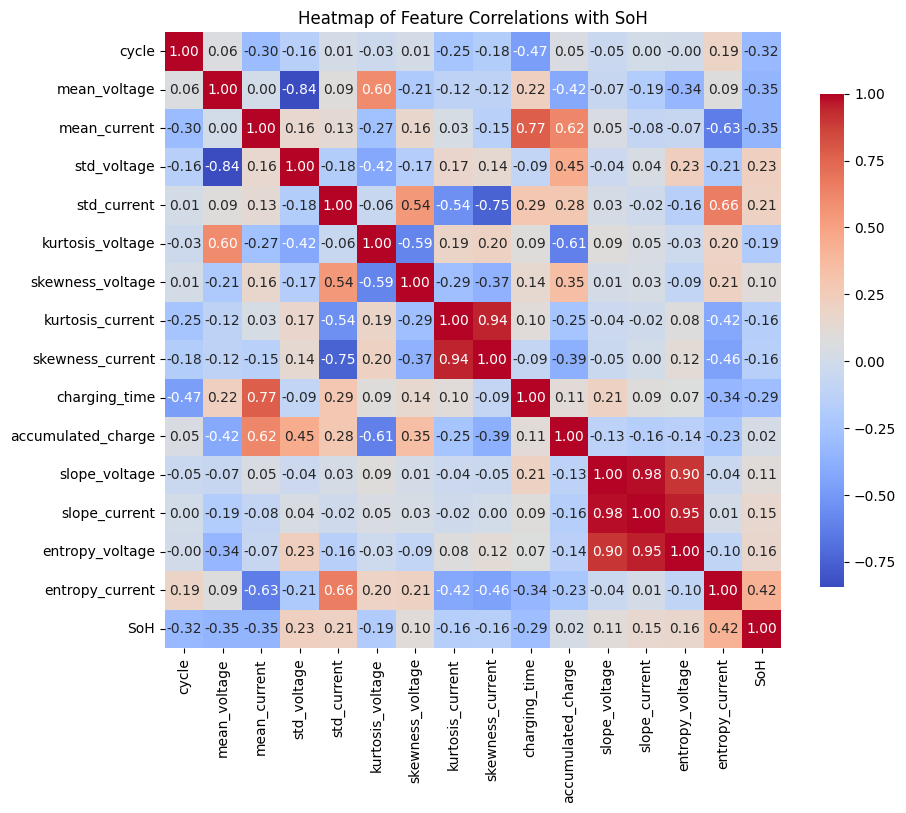

Pearson Correlation Coefficients with SoH (Sorted):
entropy_current       0.417262
std_voltage           0.228381
std_current           0.213808
entropy_voltage       0.163429
slope_current         0.151536
slope_voltage         0.105373
skewness_voltage      0.103640
accumulated_charge    0.023235
skewness_current     -0.155899
kurtosis_current     -0.160153
kurtosis_voltage     -0.190167
charging_time        -0.290767
cycle                -0.321727
mean_voltage         -0.347806
mean_current         -0.348155
Name: SoH, dtype: float64


In [ ]:
# Calculate the Pearson correlation coefficients
correlation_matrix = combined_features_df.corr(method='pearson')

# Extract the correlation of features with SoH
soh_correlation = correlation_matrix['SoH'].drop('SoH')  # Drop SoH itself to focus on features

# Sort the correlations in decreasing order
soh_correlation_sorted = soh_correlation.sort_values(ascending=False)

# Create a heatmap for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Heatmap of Feature Correlations with SoH')
plt.show()

# Print the sorted correlations with SoH for reference
print("Pearson Correlation Coefficients with SoH (Sorted):")
print(soh_correlation_sorted)

# Negating the correlation of the following features with SoH, so that they have highly positive corelation from high negative corelation

In [ ]:
combined_features_df['charging_time'] = -combined_features_df['charging_time']
combined_features_df['cycle'] = -combined_features_df['cycle']
combined_features_df['mean_current'] = -combined_features_df['mean_current']
combined_features_df['mean_voltage'] = -combined_features_df['mean_voltage']

# Updated/New Pearson Correlation

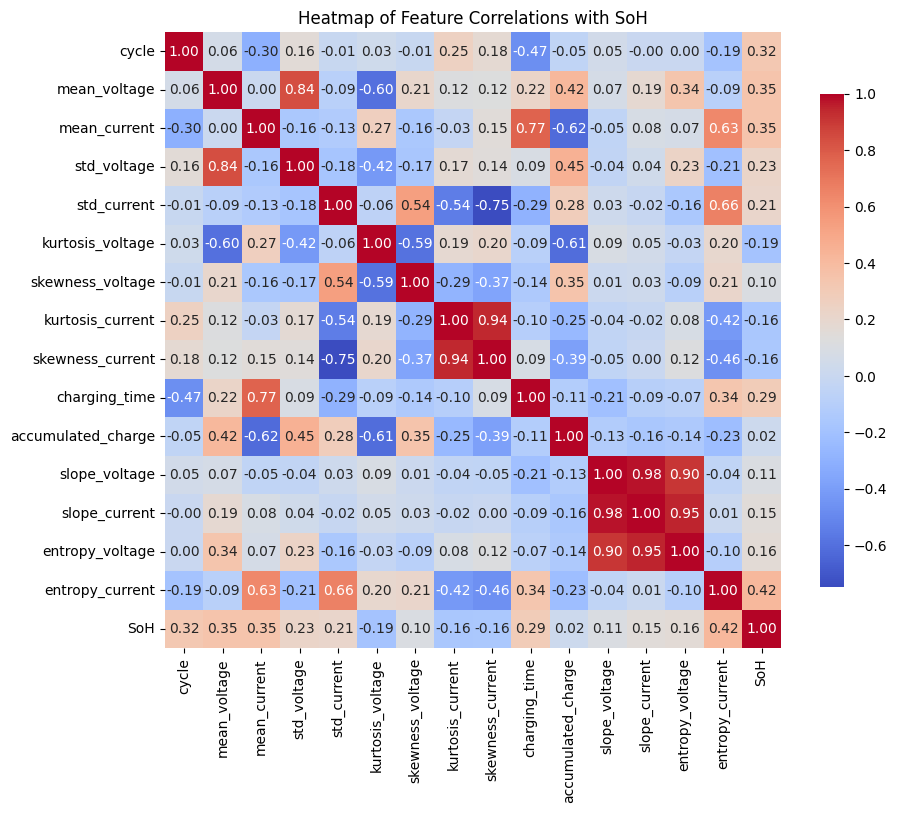

New Pearson Correlation Coefficients with SoH (Sorted):
entropy_current       0.417262
mean_current          0.348155
mean_voltage          0.347806
cycle                 0.321727
charging_time         0.290767
std_voltage           0.228381
std_current           0.213808
entropy_voltage       0.163429
slope_current         0.151536
slope_voltage         0.105373
skewness_voltage      0.103640
accumulated_charge    0.023235
skewness_current     -0.155899
kurtosis_current     -0.160153
kurtosis_voltage     -0.190167
Name: SoH, dtype: float64


In [ ]:
# Calculate the Pearson correlation coefficients
correlation_matrix = combined_features_df.corr(method='pearson')

# Extract the correlation of features with SoH
soh_correlation = correlation_matrix['SoH'].drop('SoH')  # Drop SoH itself to focus on features

# Sort the correlations in decreasing order
soh_correlation_sorted = soh_correlation.sort_values(ascending=False)

# Create a heatmap for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Heatmap of Feature Correlations with SoH')
plt.show()

# Print the sorted correlations with SoH for reference
print("New Pearson Correlation Coefficients with SoH (Sorted):")
print(soh_correlation_sorted)


# Training phase for calculating SoH

### Taking the top 7 highly correalted features

In [ ]:
from sklearn.model_selection import train_test_split

choosen_features = [
    'entropy_current',
    'mean_current',
    'mean_voltage',
    'cycle',
    'charging_time',
    'std_voltage',
    'std_current',
    'SoH'
]

train_dataset = combined_features_df[choosen_features]
train_dataset = train_dataset[train_dataset['SoH'] != 0]

soh = train_dataset['SoH']
train_dataset = train_dataset.drop(columns = ['SoH'])

scaler = MinMaxScaler(feature_range=(0,1))
train_dataset = scaler.fit_transform(train_dataset)

X_train, X_test, y_train, y_test = train_test_split(train_dataset, soh, test_size = 0.2, random_state=42, shuffle = True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1108, 7) (278, 7) (1108,) (278,)


# ExtraTrees Model

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

# Initialize and train the Extra Trees Regressor
model = ExtraTreesRegressor(n_estimators=1000, random_state=42)  # You can adjust n_estimators as needed
model.fit(X_train, y_train)

ExtraTreesRegressor(n_estimators=1000, random_state=42)

# Testing to test the SoH prediction model

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
# print(y_pred.shape, y_test.shape)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Calculate accuracy
accuracy = 1 - np.mean(np.abs((y_test - y_pred) / y_test))

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Accuracy Score: {accuracy}")

Mean Absolute Error (MAE): 0.74
Mean Squared Error (MSE): 1.73
Root Mean Squared Error (RMSE): 1.32
R-squared (R²): 1.00
Accuracy Score: 0.9928433504713539


# Finally both SoH are plotted to observe their differences

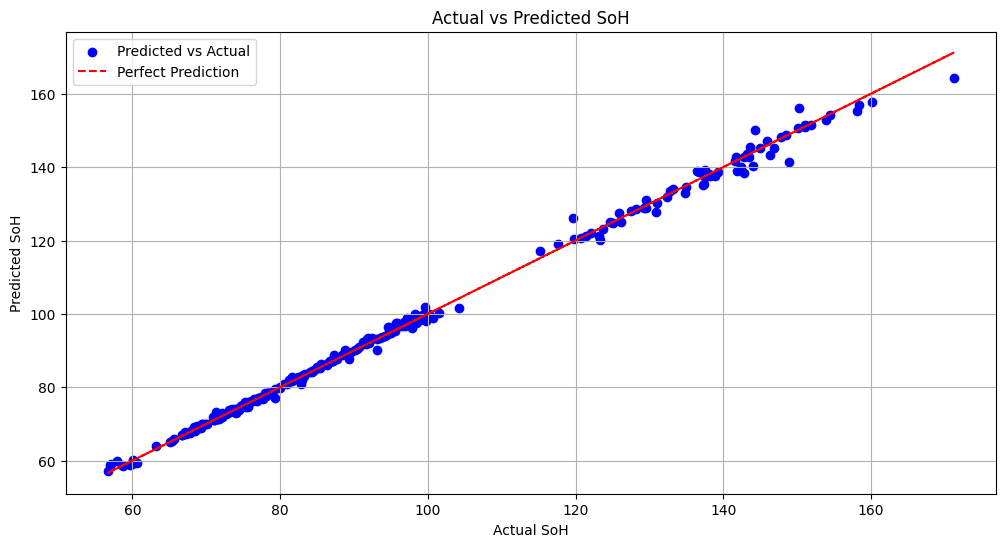

In [ ]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Plotting the actual vs. predicted values
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Perfect Prediction')  # Line for perfect prediction
plt.xlabel('Actual SoH')
plt.ylabel('Predicted SoH')
plt.title('Actual vs Predicted SoH')
plt.legend()
plt.grid()

For the estimation of SoH, it can be seen that the data pattern is learned by the model correctly, as predicted by the theory, since the shape of the curves is almost identical. The SoH shown has the same behavior as expected in theory, which is corroborated with the root mean square error value. This reaffirms the precision when making the prediction.

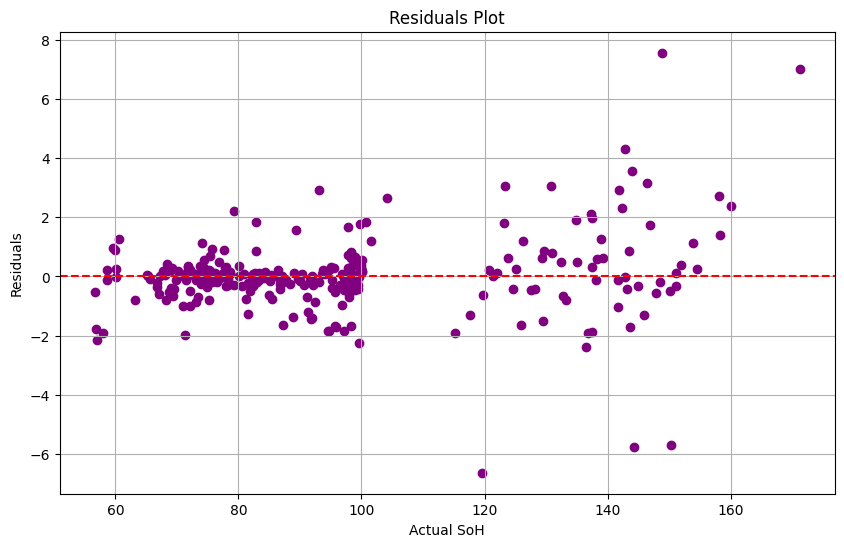

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual SoH')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

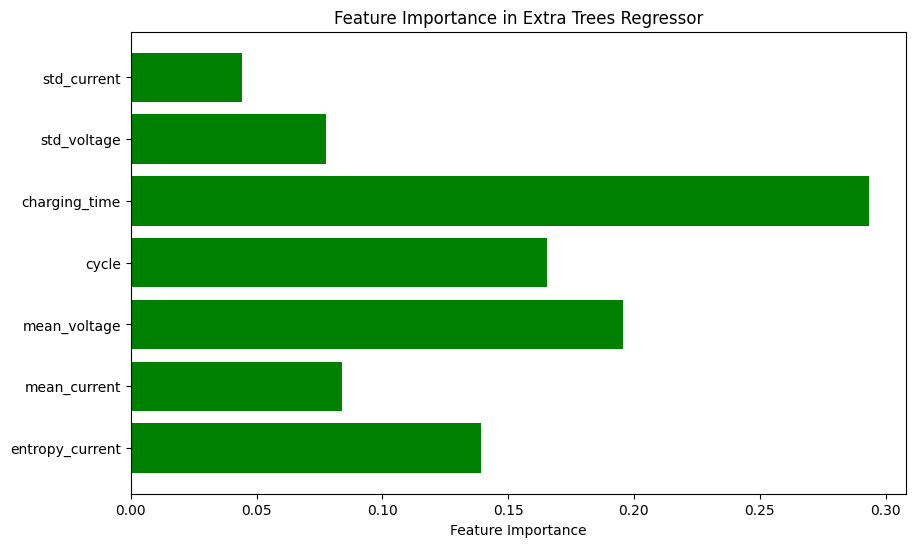

entropy_current: 0.13930261981757705
mean_current: 0.0840780029547167
mean_voltage: 0.19584354812575555
cycle: 0.16537139724788416
charging_time: 0.29336553281383704
std_voltage: 0.07778391252285692
std_current: 0.04425498651737248


In [ ]:
choosen_features_ = [
    'entropy_current',
    'mean_current',
    'mean_voltage',
    'cycle',
    'charging_time',
    'std_voltage',
    'std_current'
]

importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(choosen_features_, importances, color='green')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Extra Trees Regressor')
plt.show()

for i in range(len(choosen_features)):
    print(f'{choosen_features[i]}: {importances[i]}')

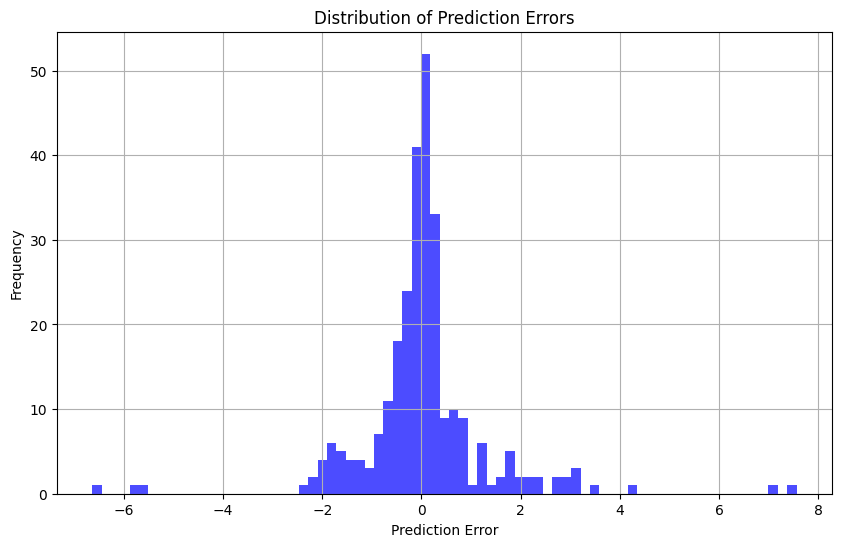

In [ ]:
error = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(error, bins=75, color='blue', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()

# Building the CNN Transformer

In [ ]:
!pip install torch torchvision

# 1D CNN Transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


# Step 1: Data Preparation
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def prepare_data(df, target_col, test_size=0.2, batch_size=32):
    # Separate features and target
    X = df.drop(target_col, axis=1).values
    y = df[target_col].values

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create datasets
    train_dataset = TabularDataset(X_train_scaled, y_train)
    test_dataset = TabularDataset(X_test_scaled, y_test)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, scaler

# Step 2: Model Definition
class CNNTransformerTabular(nn.Module):
    def __init__(self, input_dim, cnn_output_dim, d_model, nhead, num_layers, dropout=0.1):
        super(CNNTransformerTabular, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, cnn_output_dim, kernel_size=3, padding=1)

        # Transformer layers
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=cnn_output_dim, nhead=nhead, dropout=dropout),
            num_layers=num_layers
        )

        # Output layer
        self.fc = nn.Linear(cnn_output_dim, 1)

    def forward(self, x):
        # Reshape input for CNN (batch_size, channels, sequence_length)
        x = x.unsqueeze(1)

        # CNN layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))

        # Transformer layers (transformer expects: sequence_length, batch_size, d_model)
        x = x.permute(2, 0, 1)
        x = self.transformer(x)

        # Global average pooling
        x = torch.mean(x, dim=0)

        # Output layer
        x = self.fc(x)
        return x

In [ ]:
# Step 3: Training Function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

# Step 4: Testing Function
def test_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_targets = []
    all_outputs = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_outputs = np.array(all_outputs)

    mse = mean_squared_error(all_targets, all_outputs)
    mae = mean_absolute_error(all_targets, all_outputs)
    r2 = r2_score(all_targets, all_outputs)
    accuracy = 1 - np.mean(np.abs((all_targets - all_outputs) / all_targets))

    return total_loss / len(test_loader), mse, mae, r2, accuracy, all_targets, all_outputs

# Step 5: Plotting Function
def plot_metrics(train_losses, test_losses, mses, maes, r2s, accuracies):
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))

    axs[0, 0].plot(train_losses, label='Train Loss')
    axs[0, 0].plot(test_losses, label='Test Loss')
    axs[0, 0].set_title('Loss over epochs')
    axs[0, 0].legend()

    axs[0, 1].plot(mses)
    axs[0, 1].set_title('MSE over epochs')

    axs[1, 0].plot(maes)
    axs[1, 0].set_title('MAE over epochs')

    axs[1, 1].plot(r2s)
    axs[1, 1].set_title('R2 Score over epochs')

    axs[2, 0].plot(accuracies)
    axs[2, 0].set_title('Accuracy over epochs')

    plt.tight_layout()
    plt.show()
    # plt.savefig('training_metrics.png')
    # plt.close()

# Step 6: Prediction Function
def predict(model, scaler, input_data, device):
    model.eval()
    # Ensure input_data is 2D
    if input_data.ndim == 1:
        input_data = input_data.reshape(1, -1)

    # Scale the input data
    scaled_data = scaler.transform(input_data)

    # Convert to tensor
    input_tensor = torch.tensor(scaled_data, dtype=torch.float32).to(device)

    with torch.no_grad():
        output = model(input_tensor)

    return output.cpu().numpy()

In [ ]:
combined_features_df = combined_features_df[combined_features_df['SoH'] != 0]

train_dataset = combined_features_df[choosen_features]
train_dataset

,entropy_current,mean_current,mean_voltage,cycle,charging_time,std_voltage,std_current,SoH
0,-39.336811,1.990533,-3.556946,-1,-3690.234,0.226595,0.202011,100.000000
1,-39.367648,1.990278,-3.561476,-2,-3672.344,0.232008,0.202426,99.498985
2,-39.388808,1.989947,-3.566752,-3,-3651.641,0.224124,0.202994,98.918547
3,-39.368330,1.989601,-3.568795,-4,-3631.563,0.221551,0.203501,98.916498
4,-39.410114,1.989548,-3.563971,-5,-3629.172,0.235643,0.203319,98.289755
...,...,...,...,...,...,...,...,...
1393,-39.364469,1.990856,-3.077470,-51,-2345.000,0.428067,0.208440,98.734924
1394,-39.320559,1.991047,-3.065651,-52,-2363.047,0.423930,0.208020,93.636929
1395,-39.258813,1.990491,-3.087680,-53,-2316.687,0.409291,0.210270,97.899449
1396,-39.303709,1.990194,-3.080080,-54,-2322.000,0.411531,0.210894,97.946004


In [ ]:
# Loading the Data
df = train_dataset

# Prepare data
train_loader, test_loader, scaler = prepare_data(df, target_col='SoH')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
input_dim = df.shape[1] - 1  # number of features
model = CNNTransformerTabular(input_dim=input_dim, cnn_output_dim=64, d_model=64, nhead=4, num_layers=2).to(device)

# Set up loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 250
train_losses, test_losses, mses, maes, r2s, accuracies = [], [], [], [], [], []

for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        test_loss, mse, mae, r2, accuracy, _, _ = test_model(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        mses.append(mse)
        maes.append(mae)
        r2s.append(r2)
        accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
              f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, Accuracy: {accuracy:.4f}")

print("Training complete!")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/250, Train Loss: 8623.3063, Test Loss: 8594.0696, MSE: 8576.6396, MAE: 88.8368, R2: -11.5265, Accuracy: 0.0793
Epoch 2/250, Train Loss: 8083.3684, Test Loss: 8052.2953, MSE: 8035.2798, MAE: 85.7357, R2: -10.7358, Accuracy: 0.1138
Epoch 3/250, Train Loss: 7483.4958, Test Loss: 7420.2965, MSE: 7403.7842, MAE: 81.9702, R2: -9.8135, Accuracy: 0.1558
Epoch 4/250, Train Loss: 6820.2496, Test Loss: 6722.6311, MSE: 6706.7017, MAE: 77.6017, R2: -8.7954, Accuracy: 0.2044
Epoch 5/250, Train Loss: 6124.7312, Test Loss: 5994.6385, MSE: 5979.3550, MAE: 72.7645, R2: -7.7331, Accuracy: 0.2582
Epoch 6/250, Train Loss: 5417.0570, Test Loss: 5258.3492, MSE: 5243.7661, MAE: 67.5210, R2: -6.6587, Accuracy: 0.3166
Epoch 7/250, Train Loss: 4692.2059, Test Loss: 4536.3511, MSE: 4522.5117, MAE: 61.9502, R2: -5.6053, Accuracy: 0.3786
Epoch 8/250, Train Loss: 3995.9742, Test Loss: 3848.8058, MSE: 3835.7432, MAE: 56.1343, R2: -4.6022, Accuracy: 0.4434
Epoch 9/250, Train Loss: 3360.8228, Test Loss: 3223.13

Final Evaluation - MSE: 4.1651, MAE: 1.5177, R2: 0.9939, Accuracy: 0.9843


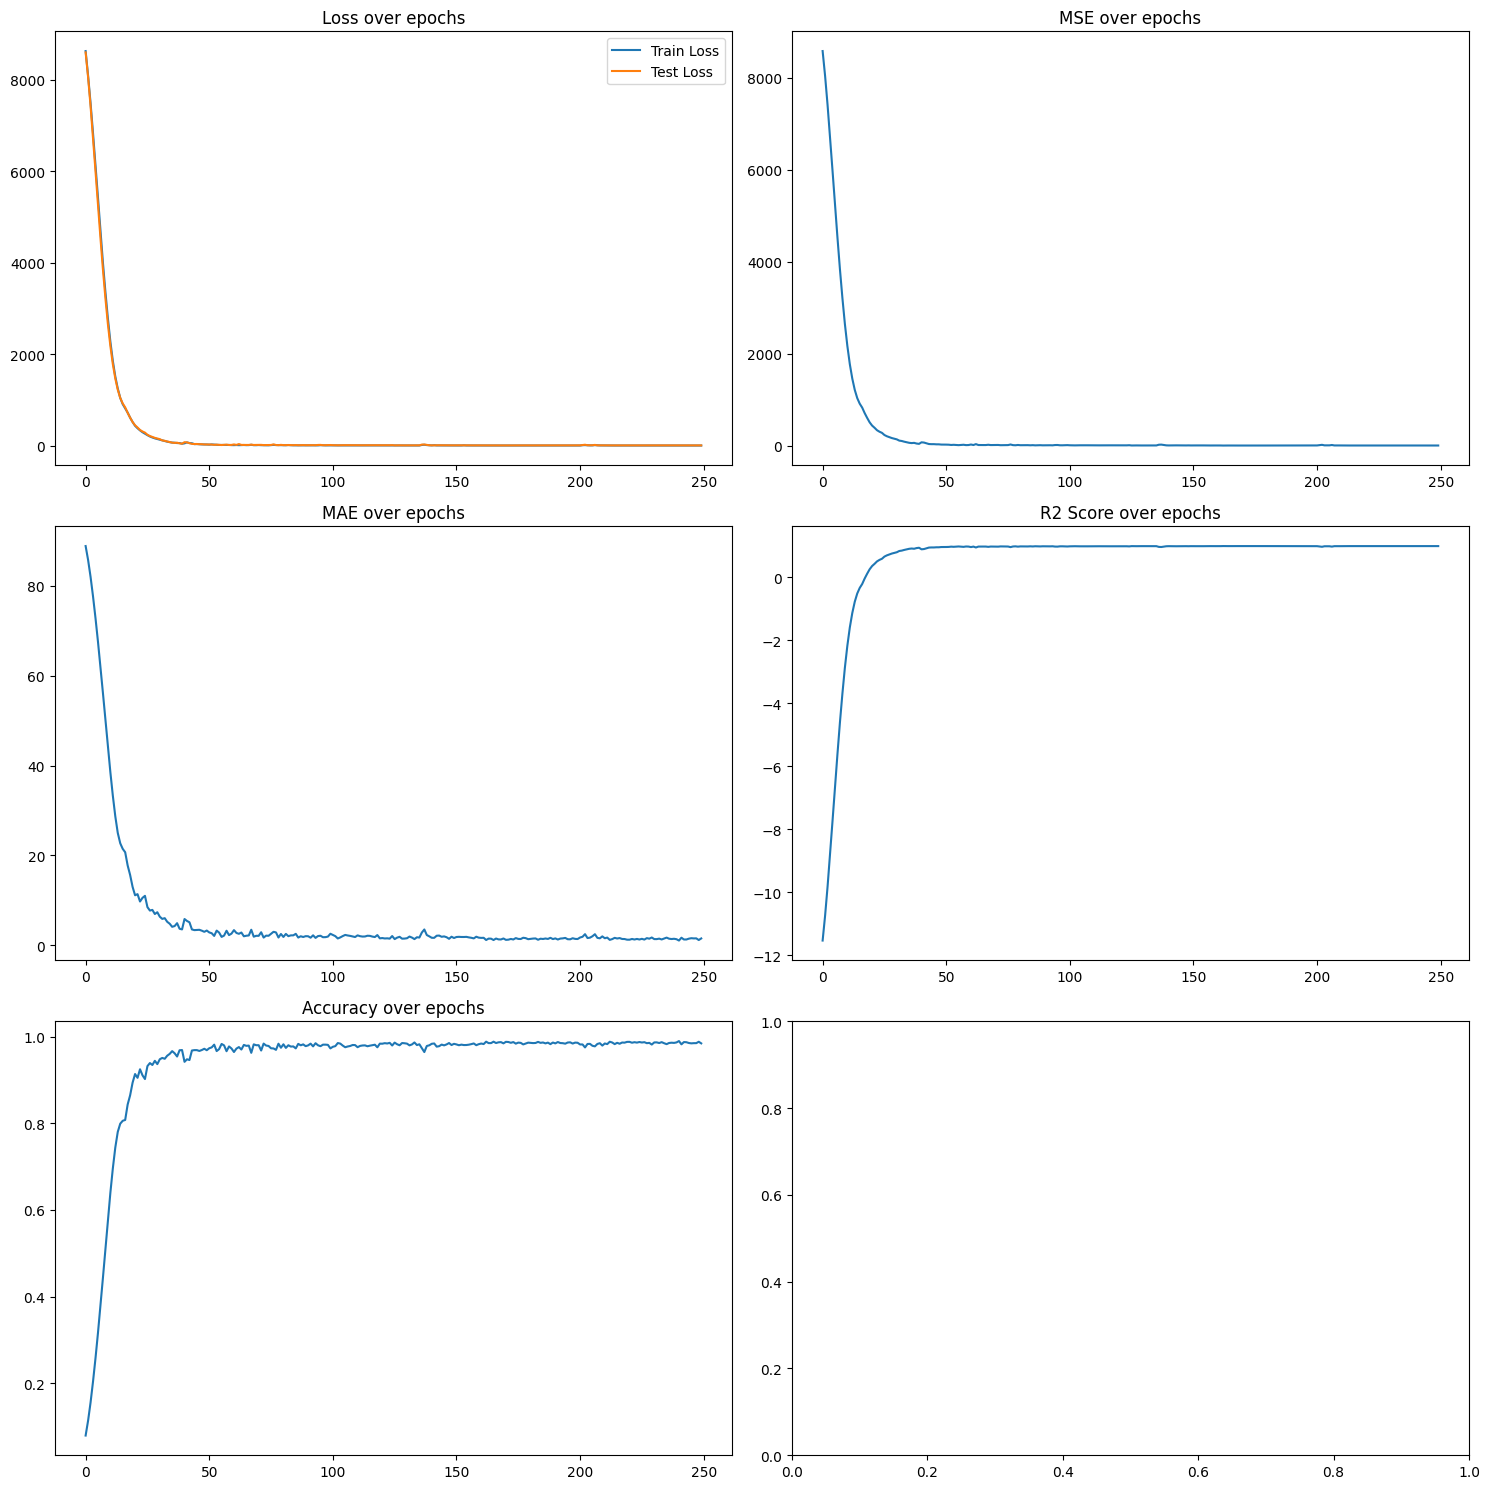

In [ ]:
# # Save the model
# torch.save(model.state_dict(), 'cnn_transformer_tabular_model.pth')

# Final evaluation
_, mse, mae, r2, accuracy, targets, outputs = test_model(model, test_loader, criterion, device)
print(f"Final Evaluation - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, Accuracy: {accuracy:.4f}")

# Plot metrics
plot_metrics(train_losses, test_losses, mses, maes, r2s, accuracies)

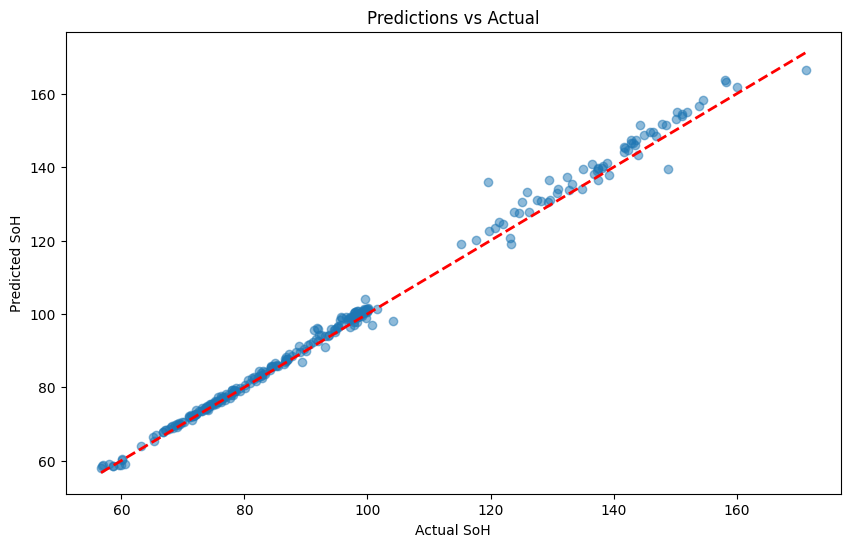

In [ ]:
# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(targets, outputs, alpha=0.5)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--', lw=2)
plt.xlabel('Actual SoH')
plt.ylabel('Predicted SoH')
plt.title('Predictions vs Actual')
# plt.savefig('predictions_vs_actual.png')
# plt.close()
plt.show()

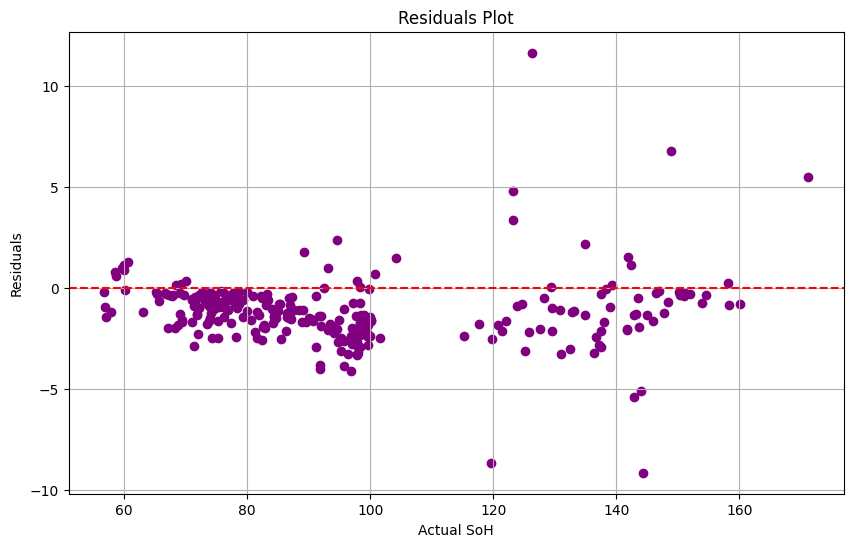

In [ ]:
residuals = targets - outputs
plt.figure(figsize=(10, 6))
plt.scatter(targets, residuals, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual SoH')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

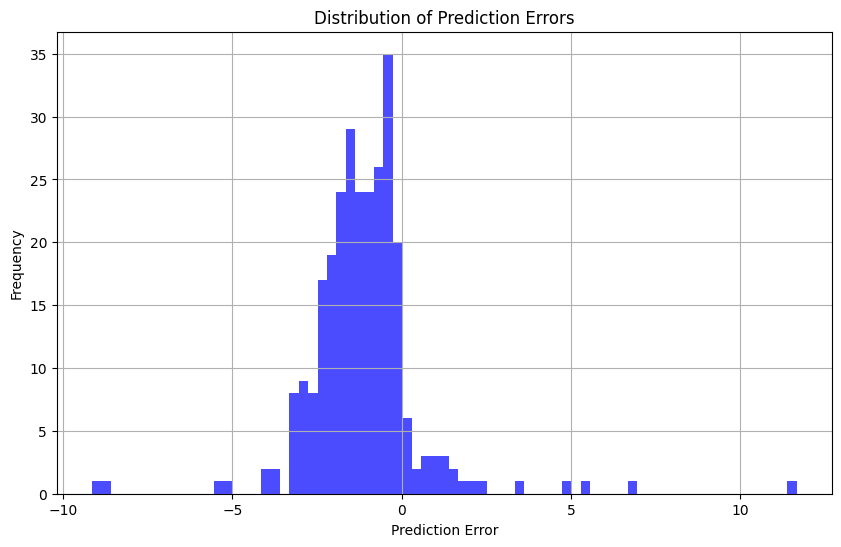

In [ ]:
error = targets - outputs
plt.figure(figsize=(10, 6))
plt.hist(error, bins=75, color='blue', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()